In [0]:
# from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import pandas as pd

In [0]:
from __future__ import division
from __future__ import print_function

import random
import numpy as np
import cv2
import imutils
from google.colab.patches import cv2_imshow

def preprocess(img, imgSize, dataAugmentation=False):
	"put img into target img of size imgSize, transpose for TF and normalize gray-values"

	# there are damaged files in IAM dataset - just use black image instead
	if img is None:
		img = np.zeros([imgSize[1], imgSize[0]])
		print('test')
	img = cv2.resize(img, imgSize)
	img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
	imgBlurred = cv2.GaussianBlur(img, (5,5), 0)                        # blur

  #                                                       # filter image from grayscale to black and white
	imgThresh = cv2.adaptiveThreshold(img,                           # input image
                                      255,                                  # make pixels that pass the threshold full white
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,       # use gaussian rather than mean, seems to give better results
                                      cv2.THRESH_BINARY_INV,                # invert so foreground will be white, background will be black
                                      11,                                   # size of a pixel neighborhood used to calculate threshold value
                                      2)                                    # constant subtracted from the mean or weighted mean

  #   # cv2.imshow("imgThresh", imgThresh)
	# cv2_imshow(img)
	# return img
	return imgThresh
	# cv2_imshow(imgThresh)

In [0]:
img = cv2.imread('/content/drive/My Drive/APM Project/Data/Characters only/Img/Sample029/img029-003.png', cv2.IMREAD_UNCHANGED) #change the path here
imgSize = (40, 30)
preprocess(img, imgSize)
# cv2_imshow(img)

In [0]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [0]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 1200 # MNIST data input (img shape: 28*28)
num_classes = 62 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [0]:
image_labels = pd.read_csv('/content/drive/My Drive/APM Project/Data/Characters only/Label file.csv',header = None)
image_labels.columns = ['Image Path','Label','Mapping']
x=[]
imgSize = (40, 30)
for i in range(len(image_labels)):
  img = preprocess(np.uint8(cv2.imread('/content/drive/My Drive/APM Project/Data/Characters only/'+image_labels['Image Path'][i])), imgSize)
  x.append(img)

In [0]:
y=[]
y=image_labels['Mapping'].to_list()

In [0]:
df = pd.DataFrame({'x': x, 'y': y})
m = pd.DataFrame(np.random.randn(3410, 2))
msk = np.random.rand(len(m)) < 0.8
train_df = df[msk]
test_df = df[~msk]

In [0]:
x_train = train_df['x'].to_list()
y_train = train_df['y'].to_list()
x_train1 = np.asarray(x_train)
x_train2 = x_train1.reshape(-1,1200).astype(np.float32)
y_train1 = np.asarray(y_train)
y_train2 = y_train1.astype(np.uint8)

In [0]:
x_test = test_df['x'].to_list()
y_test = test_df['y'].to_list()
x_test1 = np.asarray(x_test)
x_test2 = x_test1.reshape(-1,1200).astype(np.float32)
y_test1 = np.asarray(y_test)
y_test2 = y_test1.astype(np.uint8)

In [0]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 30, 40, 1])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 10, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 6, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out

In [0]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [0]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpy0ols6ss', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f868315f908>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_train2}, y=y_train2,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updat

In [0]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': x_test2}, y=y_test2,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-12-05T00:14:15Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy0ols6ss/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-12-05-00:14:15
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.57202214, global_step = 2000, loss = 7.7469087
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2000: /tmp/tmpy0ols6ss/model.ckpt-2000


{'accuracy': 0.57202214, 'global_step': 2000, 'loss': 7.7469087}

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpy0ols6ss/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


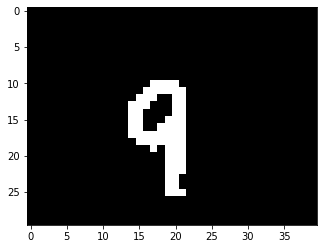

Model prediction: 42


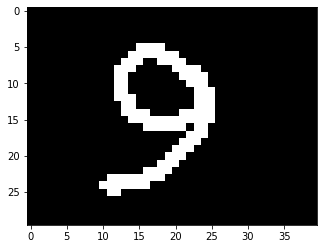

Model prediction: 17


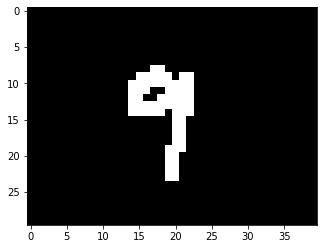

Model prediction: 9


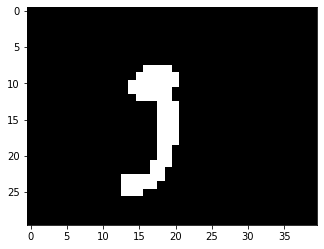

Model prediction: 9


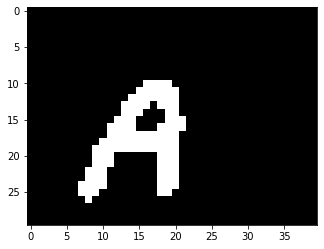

Model prediction: 42


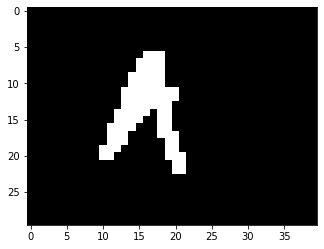

Model prediction: 27


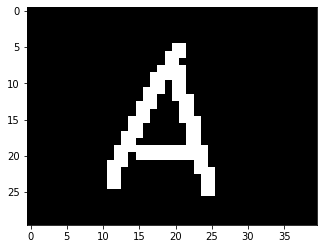

Model prediction: 4


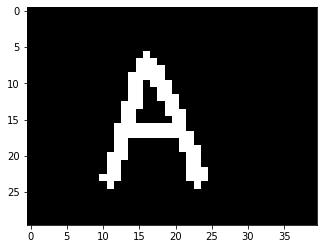

Model prediction: 10


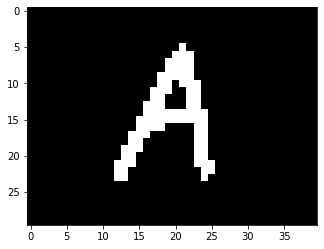

Model prediction: 10


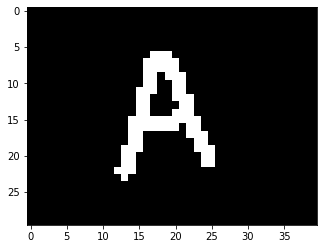

Model prediction: 10


In [0]:
# Predict single images
n_images = 10
# Get images from test set
test_images = x_test2[101:111]
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': test_images}, shuffle=False)
# Use the model to predict the images class
preds = list(model.predict(input_fn))

# Display
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [30, 40]), cmap='gray')
    plt.show()
    print("Model prediction:", preds[i])